In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Fragments
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np
import copy
from rdkit.Chem import AllChem
import itertools
rdBase.DisableLog('rdApp.error')

In [2]:
def checkmol(mol):
    arom_atoms = mol.GetAromaticAtoms()
    symbols = [atom.GetSymbol() for atom in arom_atoms if not atom.IsInRingSize(5)]
    if symbols == []:
        return True
    elif 'O' in symbols or 'S' in symbols:
        return False
    else:
        return True

In [3]:
class HeteroShuffle():
    
    def __init__(self, mol, query):
        self.mol = mol
        self.query = query
        self.subs = Chem.ReplaceCore(self.mol, self.query)
        self.core = Chem.ReplaceSidechains(self.mol, self.query)
        self.target_atomic_nums = [6, 7, 8, 16]
    
    
    def make_connectors(self):
        n = len(Chem.MolToSmiles(self.subs).split('.'))
        map_no = n+1
        self.rxn_dict = {}
        for i in range(n):
            self.rxn_dict[i+1] = AllChem.ReactionFromSmarts('[{0}*][*:{1}].[{0}*][*:{2}]>>[*:{1}][*:{2}]'.format(i+1, map_no, map_no+1))
        return self.rxn_dict

    def re_construct_mol(self, core):
        '''
        re construct mols from given substructures and core
        '''
        keys = self.rxn_dict.keys()
        ps = [[core]]
        for key in keys:
            ps = self.rxn_dict[key].RunReactants([ps[0][0], self.subs])
        mol = ps[0][0]
        try:
            smi = Chem.MolToSmiles(mol)
            mol = Chem.MolFromSmiles(smi)
            Chem.SanitizeMol(mol)
            return mol
        except:
            return None

    def get_target_atoms(self):
        '''
        get target atoms for replace
        target atoms means atoms which don't have anyatom(*) in neighbors
        '''
        atoms = []
        for atom in self.core.GetAromaticAtoms():
            neighbors = [a.GetSymbol() for a in atom.GetNeighbors()]
            if '*' not in neighbors and atom.GetSymbol() !='*':
                atoms.append(atom)
        print(len(atoms))
        return atoms
    
    def generate_mols(self):
        atoms = self.get_target_atoms()
        idxs = [atom.GetIdx() for atom in atoms]
        combinations = itertools.product(self.target_atomic_nums, repeat=len(idxs))
        smiles_set = set()
        self.make_connectors()
        for combination in combinations:
            target = copy.deepcopy(self.core)
            #print(Chem.MolToSmiles(target))
            for i, idx in enumerate(idxs):
                target.GetAtomWithIdx(idx).SetAtomicNum(combination[i])
            smi = Chem.MolToSmiles(target)
            #smi = smi.replace('sH','s').replace('oH','o').replace('cH3','c')
            #print('rep '+smi)
            target = Chem.MolFromSmiles(smi)
            if target != None:
                n_attachment = len([atom for atom in target.GetAtoms() if atom.GetAtomicNum() == 0])
                n_aromatic_atoms = len(list(target.GetAromaticAtoms()))
                if target.GetNumAtoms() - n_attachment == n_aromatic_atoms:
                    try:
                        mol = self.re_construct_mol(target)  
                        if checkmol(mol):
                            smiles_set.add(Chem.MolToSmiles(mol))
                    except:
                        pass
        mols = [Chem.MolFromSmiles(smi) for smi in smiles_set]
        return mols

In [4]:
# Gefitinib
mol1 = Chem.MolFromSmiles('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4')
core1 = Chem.MolFromSmiles('c1ccc2c(c1)cncn2')
#  Oxaprozin
mol2 = Chem.MolFromSmiles('OC(=O)CCC1=NC(=C(O1)C1=CC=CC=C1)C1=CC=CC=C1')
core2 =  Chem.MolFromSmiles('c1cnco1')

In [6]:
ht=HeteroSuffle(mol1, core1)
res=ht.generate_mols()
print(len(res))

7
32


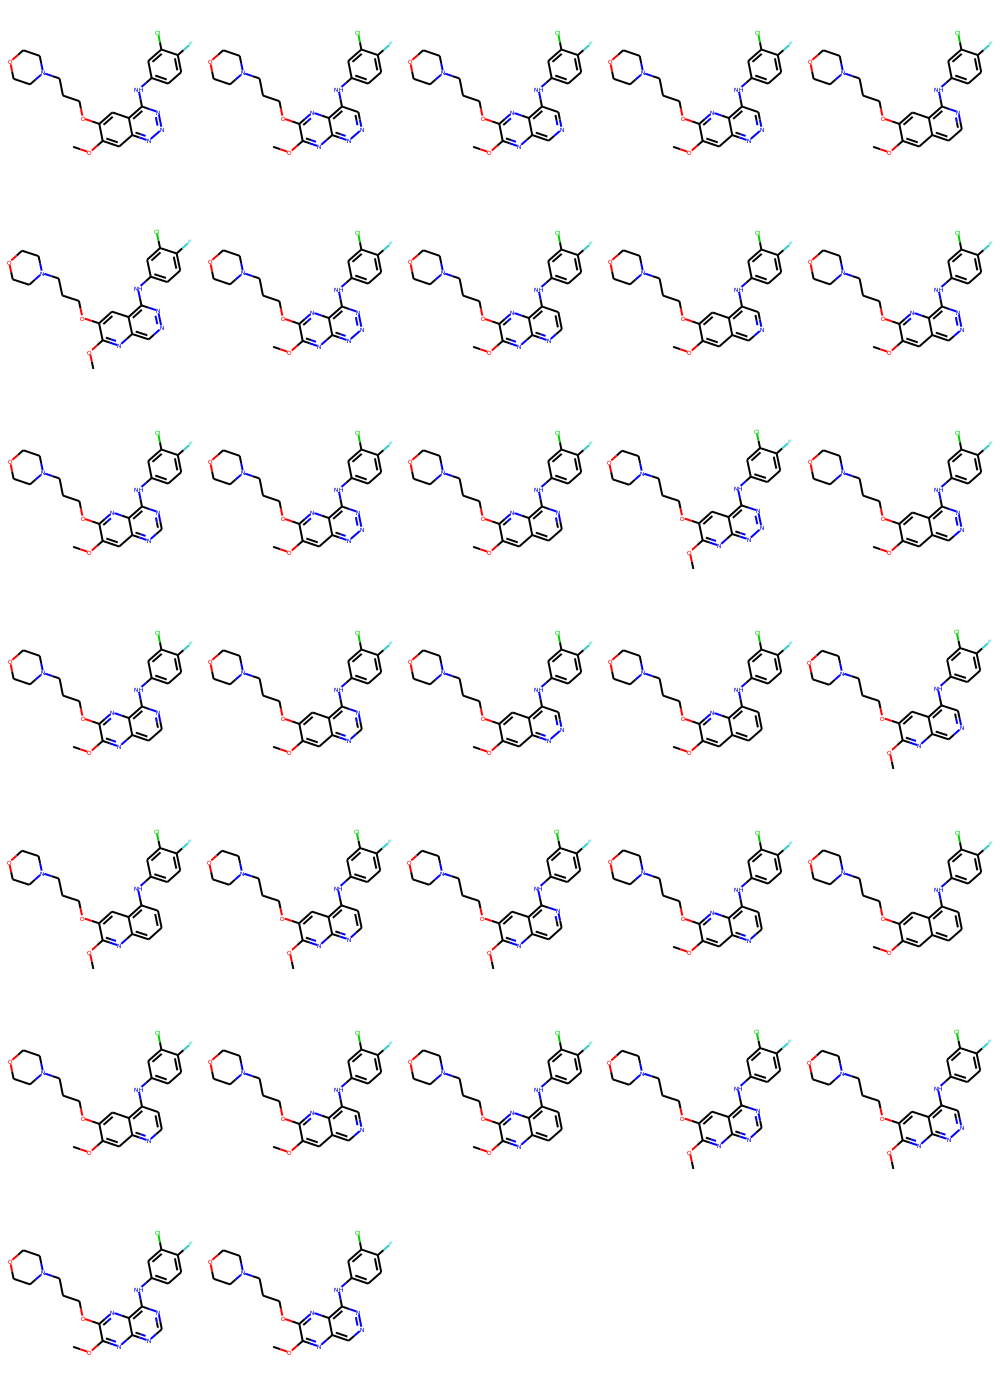

In [8]:
Draw.MolsToGridImage(res, molsPerRow=5)

In [9]:
ht=HeteroSuffle(mol2, core2)
res=ht.generate_mols()
print(len(res))

2
4


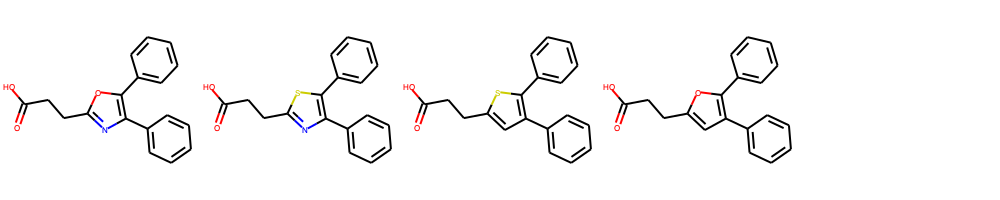

In [10]:
Draw.MolsToGridImage(res, molsPerRow=5)